# Model Tuning

This notebook includes a hyperparameter tuning and feature selection exercise for the top performing classifier. The objective is to narrow down which TML features and hyperparameters will be used in the next phase of scaling to jurisdictional scale maps.

In [68]:
import matplotlib.pyplot as plt
import seaborn as sns
import sys
sys.path.append('../src/prototype')
import prepare_data as pp
import run_preds as rp
import score_classifier as score
import pandas as pd
import pickle
from catboost import CatBoostClassifier
from sklearn.model_selection import cross_val_score, GridSearchCV, RandomizedSearchCV
from sklearn.metrics import roc_curve, roc_auc_score, precision_recall_curve, f1_score, precision_score, recall_score, confusion_matrix, ConfusionMatrixDisplay

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Feature Selection
Evaluate feature importance for the top performing MVP model (Catboost). Training with only the most important features will help to reduce overfitting and training time, while improving accuracy by removing misleading data and noise. I want to narrow down the 65 TML features to 15 with the highest feature importance.  
  
Index `0`: slope  
Index `1:3`: s1  
Index `3:13`: s2  
Index `13:77`: TML features (`78` is TML tree probability)

In [61]:
df = pd.read_csv('../models/mvp_scores.csv')
df[df['model'].str.contains('^cat_model_v10.*') == True]

,model,cv,train_score,test_score,roc_auc,precision,recall,f1,date
14,cat_model_v10_np,0.8908,0.9969,0.8518,0.9302,0.9210,0.7865,0.8485,NaN
19,cat_model_v10_nf,0.8957,0.9850,0.8262,0.9101,0.9053,0.7489,0.8197,NaN
27,cat_model_v10,0.8884,0.9972,0.8523,0.9291,0.9239,0.7847,0.8487,NaN
40,cat_model_v10,0.9073,0.9982,0.8269,0.9126,0.8695,0.7876,0.8265,11/7/22
41,cat_model_v10_nf,0.8950,0.9854,0.8293,0.9098,0.8685,0.7942,0.8297,11/7/22


In [62]:
# use the central america model w/feats
starter_model = df[40:41]
starter_model

,model,cv,train_score,test_score,roc_auc,precision,recall,f1,date
40,cat_model_v10,0.9073,0.9982,0.8269,0.9126,0.8695,0.7876,0.8265,11/7/22


In [140]:
# load original model
filename = f'../models/cat_model_v10.pkl'
with open(filename, 'rb') as file:
    model = pickle.load(file)

# calculate the feature importance 
most_important = model.get_feature_importance(prettified=True)
most_important = most_important.astype({'Feature Id': int})

# filter to only TML feats
tml_feats = most_important[most_important['Feature Id'] >= 13]

# get the top 15 most important
v10 = tml_feats.sort_values(by='Importances', ascending=False)[:15]
v10

,Feature Id,Importances
3,62,4.371062
4,71,4.046422
5,74,2.854333
9,32,2.102720
10,64,2.041282
11,54,2.014191
12,33,2.013350
13,38,1.983828
14,46,1.969877
16,16,1.717267


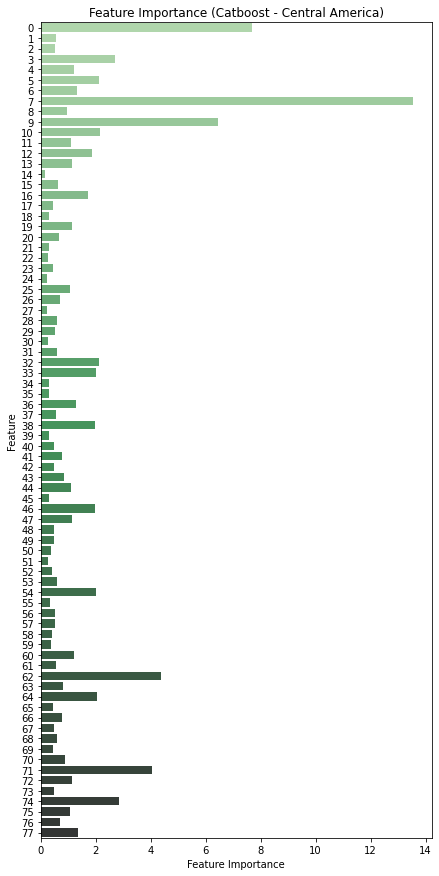

In [122]:
# view feature importance for all feats
plt.figure(figsize = (7,15))

sns.barplot(y='Feature Id', x='Importances', data=most_important, orient='h', palette="Greens_d")
plt.title('Feature Importance (Catboost - Central America)')
plt.xlabel('Feature Importance')
plt.ylabel('Feature');

## Check consistency across regions

In [126]:
# are the same features important for catboost in west africa?

filename = f'../models/cat_model_v11.pkl'
with open(filename, 'rb') as file:
    model = pickle.load(file)

# calculate the feature importance 
most_important = model.get_feature_importance(prettified=True)
most_important = most_important.astype({'Feature Id': int})

# filter to only TML feats
tml_feats = most_important[most_important['Feature Id'] >= 13]

# get the top 15 most important
v11 = tml_feats.sort_values(by='Importances', ascending=False)[:15]
v11

,Feature Id,Importances
1,71,7.007700
3,16,5.586165
6,54,3.646442
7,64,3.270772
8,76,3.261219
10,62,3.126678
11,75,2.760612
12,72,2.658921
13,74,2.524666
14,13,2.363818


In [127]:
# how about south america? (v9)
filename = f'../models/cat_model_v09.pkl'
with open(filename, 'rb') as file:
    model = pickle.load(file)

# calculate the feature importance 
most_important = model.get_feature_importance(prettified=True)
most_important = most_important.astype({'Feature Id': int})

# filter to only TML feats 
tml_feats = most_important[most_important['Feature Id'] >= 13]

# get the top 15 most important
v09 = tml_feats.sort_values(by='Importances', ascending=False)[:15]
v09

,Feature Id,Importances
2,16,5.736892
4,33,3.903781
9,51,2.772934
10,62,2.696718
11,13,2.542589
12,72,2.429293
13,24,2.274026
17,71,1.643682
18,20,1.578809
19,47,1.521576


In [129]:
# what are the common best features across three regions
list(v09['Feature Id'])

[16, 33, 51, 62, 13, 72, 24, 71, 20, 47, 77, 75, 68, 25, 38]

In [130]:
list(v10['Feature Id'])

[62, 71, 74, 32, 64, 54, 33, 38, 46, 16, 77, 36, 60, 19, 13]

In [132]:
list(v11['Feature Id'])

[71, 16, 54, 64, 76, 62, 75, 72, 74, 13, 32, 77, 20, 25, 47]

In [133]:
# check latin america similarities, then including africa
first_set = set(list(v09['Feature Id'])).intersection(set(list(v10['Feature Id'])))    
result_set = first_set.intersection(set(list(v11['Feature Id'])))
first_set, result_set

({13, 16, 33, 38, 62, 71, 77}, {13, 16, 62, 71, 77})

# Hyperparameter Tuning
Hyperparameter tuning was informed by [Catboost Documentation](https://catboost.ai/en/docs/concepts/parameter-tuning#iterations). Generally speaking, Catboost's default parameters will provide a strong result, but the tuning adjustments can bring minor improvements.

In [136]:
# use central america training data
X, y = pp.create_xy((14, 14), ['v03', 'v04', 'v10'], drop_prob=False, drop_feats=False, verbose=False)
X_train_ss, X_test_ss, y_train, y_test = pp.reshape_and_scale_manual(X, y)

Plot id 04003 has no cloud free imagery and will be removed.
Plot id 04005 has no cloud free imagery and will be removed.
Plot id 04007 has no cloud free imagery and will be removed.
Plot id 04009 has no cloud free imagery and will be removed.
Plot id 10043 has no cloud free imagery and will be removed.
Plot id 10067 has no cloud free imagery and will be removed.
Baseline: 0.483
The data has been scaled to -1.0000000000000002, 1.0000000000000002


In [138]:
iterations = [int(x) for x in np.linspace(200, 1100, 10)]            # equiv to n_estimators
depth = [int(x) for x in np.linspace(4, 10, 4)]                      # equiv to max_depth (must be <= 16)
l2_reg = [int(x) for x in np.linspace(2, 30, 4)]
learning_rate = [.01, .02, .03]                                      # decrease learning rate if overfitting 

param_dist = {'iterations': iterations,
              'depth': depth,
              'l2_leaf_reg': l2_reg,
              'learning_rate': learning_rate}

# instantiate the classifier and perform random search
cat = CatBoostClassifier(random_seed=22, verbose=False)

rds = RandomizedSearchCV(estimator=cat,
                        param_distributions=param_dist, 
                        n_iter=30,
                        cv=3,
                        random_state=22)

# Achieves 0.908
rds.fit(X_train_ss, y_train)
rds_best = rds.best_params_
print(f"The best parameters are {rds.best_params_} with a score of {rds.best_score_}")

The best parameters are {'learning_rate': 0.03, 'l2_leaf_reg': 30, 'iterations': 1100, 'depth': 4} with a score of 0.9084283317567475


In [139]:
# now fit classifier with best params and get all scores
cat_best_params = CatBoostClassifier(random_seed=22,
                                     learning_rate=0.03,
                                     l2_leaf_reg=30,
                                     iterations=1100,
                                     depth=4,
                                     verbose=False)

cat_best_params.fit(X_train_ss, y_train) 

# save trained model
filename = f'../models/cat_model_10tuned.pkl'
with open(filename, 'wb') as file:
    pickle.dump(model, file)

score.print_scores(cat_best_params, X_train_ss, X_test_ss, y_train, y_test)

cv: 0.9084
train: 0.9783
test: 0.8278
roc_auc: 0.9134
precision: 0.8702
recall: 0.7888
f1: 0.8275


In [3]:
original_model

,model,cv,train_score,test_score,roc_auc,precision,recall,f1
29,cat_model_v10,0.8884,0.9972,0.8523,0.9291,0.9239,0.7847,0.8487


## Conclusions
### Round 2
- There are commonalities across regions. In Latin America (Cental + South) there are 7 common features in the top 15 most important TML features `{13, 16, 33, 38, 62, 71, 77}`. All three regions share 5 of the most important features `{13, 16, 62, 71, 77}`. 
- For Central America, slope and s2 were also important predictors.
- Hyperparameter tuning indicated the best parameters are `{'learning_rate': 0.03, 'l2_leaf_reg': 30, 'iterations': 1100, 'depth': 4}`
- Fitting a CatBoost Classifier with selected hyperparameters did reduce overfitting.

### Round 1
- Fitting the CatboostClassifier with the top 15 TML features rather than all 65 only brought minor improvements in accuracy.
- The feature selection exercise revealed that different features are important for different regions.
- Index 7 (s2) and 67 (TML feat) ranked highly across all three regions.
- Index 77 (TML tree probability) had surprisingly low importance.
- Fitting CatboostClassifier with the best features and best parameters resulted in improvements between .01 - .1% across accuracy metrics.